In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
census_income = fetch_ucirepo(id=20) 
  
# data (as pandas dataframes) 
X = census_income.data.features 
y = census_income.data.targets 
  
# metadata 
print(census_income.metadata) 
  
# variable information 
print(census_income.variables) 


{'uci_id': 20, 'name': 'Census Income', 'repository_url': 'https://archive.ics.uci.edu/dataset/20/census+income', 'data_url': 'https://archive.ics.uci.edu/static/public/20/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data.  Also known as Adult dataset.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Sep 09 2024', 'dataset_doi': '10.24432/C5GP7S', 'creators': ['Ron Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && 

In [4]:
# ============================================
# Adult (UCI) Dataset - Detailed EDA Notebook
# ============================================

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

sns.set_theme(style="whitegrid")
#pd.set_option("display.max_columns", 200)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [5]:
# -----------------------------
# 1) Download & Load the data
# -----------------------------
import requests

DATA_DIR = "adult_uci"
os.makedirs(DATA_DIR, exist_ok=True)

train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

train_path = os.path.join(DATA_DIR, "adult.data")
test_path  = os.path.join(DATA_DIR, "adult.test")

def download_file(url, filepath):
    if os.path.exists(filepath) and os.path.getsize(filepath) > 0:
        print(f"✅ Found: {filepath}")
        return
    print(f"⬇️ Downloading: {url}")
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    with open(filepath, "wb") as f:
        f.write(r.content)
    print(f"✅ Saved: {filepath}")

download_file(train_url, train_path)
download_file(test_url, test_path)


⬇️ Downloading: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
✅ Saved: adult_uci/adult.data
⬇️ Downloading: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
✅ Saved: adult_uci/adult.test


In [6]:
# -----------------------------
# 2) Parse with correct columns
# -----------------------------
cols = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country",
    "income"
]

# adult.data has no header; adult.test includes a header line and labels have trailing '.'
train = pd.read_csv(train_path, header=None, names=cols, sep=",", skipinitialspace=True)
test  = pd.read_csv(test_path,  header=None, names=cols, sep=",", skipinitialspace=True, skiprows=1)

print(train.shape, test.shape)
train.head()


(32561, 15) (16281, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
# -----------------------------
# 3) Basic cleaning
# -----------------------------
def clean_adult(df):
    df = df.copy()

    # Standardize whitespace
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = df[c].astype(str).str.strip()

    # In test set income values are like '>50K.' and '<=50K.'
    df["income"] = df["income"].str.replace(".", "", regex=False)

    # Replace '?' with NaN in categorical columns
    df = df.replace("?", np.nan)

    # Optional: enforce target labels (in case of any stray whitespace)
    df["income"] = df["income"].replace({">50K ": ">50K", "<=50K ": "<=50K"})

    return df

train = clean_adult(train)
test  = clean_adult(test)

full = pd.concat(
    [train.assign(split="train"), test.assign(split="test")],
    ignore_index=True
)

full.sample(5, random_state=RANDOM_SEED)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,split
7762,18,Private,423024,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,20,United-States,<=50K,train
23881,17,Private,178953,12th,8,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K,train
30507,25,Local-gov,348986,HS-grad,9,Never-married,Handlers-cleaners,Other-relative,Black,Male,0,0,40,United-States,<=50K,train
28911,20,Private,218215,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,United-States,<=50K,train
19484,47,Private,244025,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,Amer-Indian-Eskimo,Male,0,0,56,Puerto-Rico,<=50K,train


In [8]:
# -----------------------------
# 4) Data overview
# -----------------------------
print("Full shape:", full.shape)
display(full.head())

# Missing values summary
missing = (full.isna().mean().sort_values(ascending=False) * 100).to_frame("missing_%")
missing["missing_count"] = full.isna().sum()
display(missing[missing["missing_count"] > 0])

# Target distribution
display(full["income"].value_counts(dropna=False))
display((full["income"].value_counts(normalize=True) * 100).round(2))


Full shape: (48842, 16)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,split
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,train
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train


,missing_%,missing_count
occupation,5.751198,2809
workclass,5.730724,2799
native-country,1.754637,857


income
<=50K    37155
>50K     11687
Name: count, dtype: int64

income
<=50K    76.07
>50K     23.93
Name: proportion, dtype: float64

In [9]:
# ------------------------------------------
# 5) Separate categorical & numeric features
# ------------------------------------------
target = "income"

cat_cols = [c for c in cols if full[c].dtype == "object" and c != target]
num_cols = [c for c in cols if full[c].dtype != "object"]

cat_cols, num_cols


(['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country'],
 ['age',
  'fnlwgt',
  'education-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'])

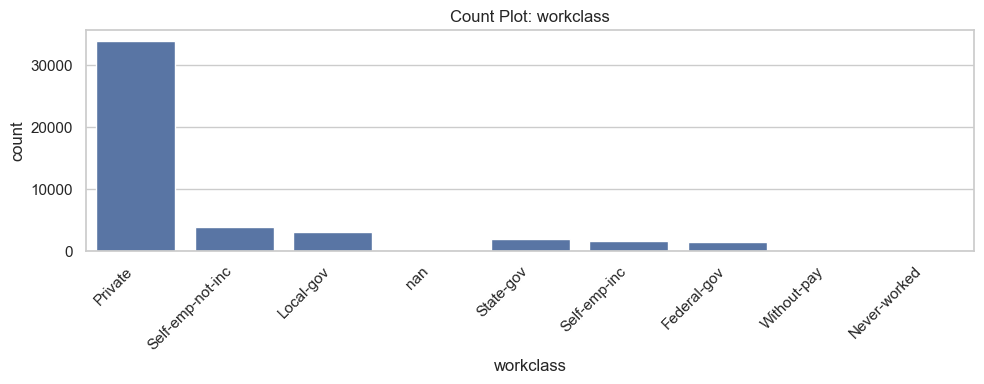

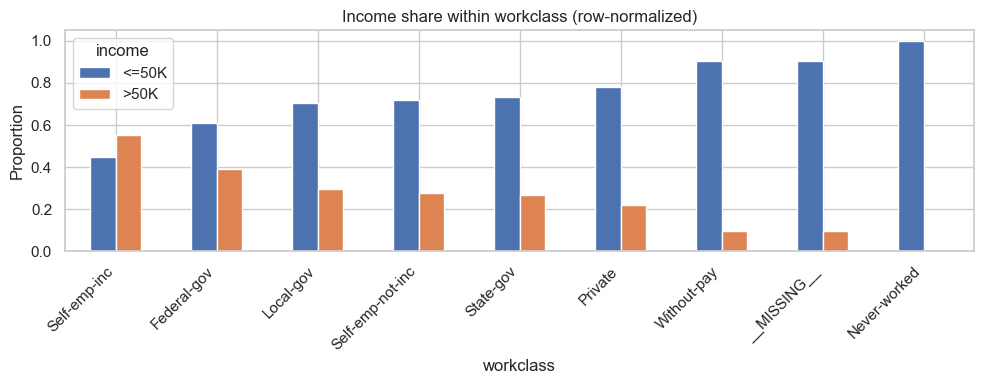

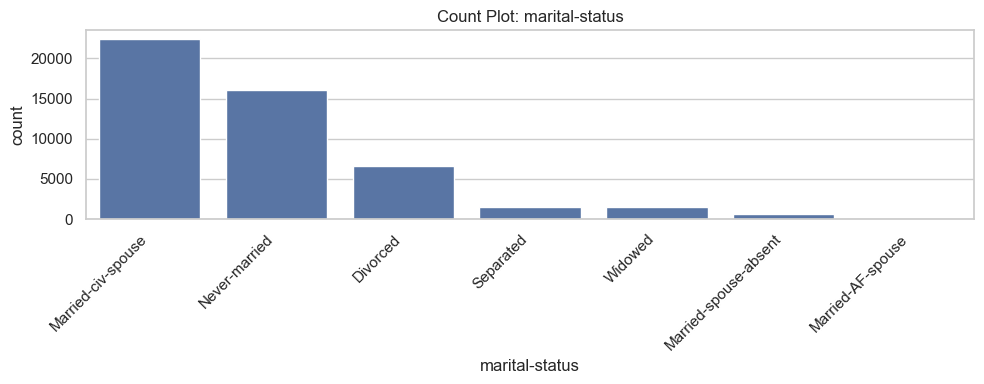

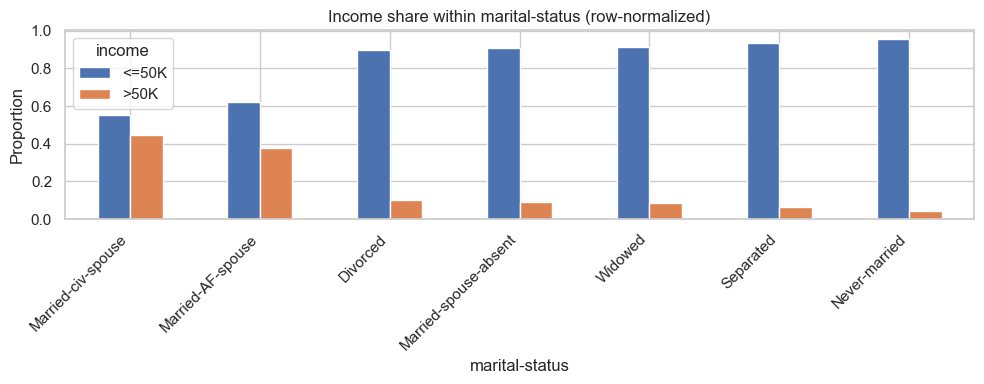

In [10]:
# ============================
# EDA Step 1:
# Categorical Profiling
# ============================

def plot_cat_counts(df, col, top_n=None):
    s = df[col].copy()
    if top_n is not None:
        top = s.value_counts(dropna=False).head(top_n).index
        s = s.where(s.isin(top), other="__OTHER__")

    order = s.value_counts(dropna=False).index

    plt.figure(figsize=(10, 4))
    ax = sns.countplot(x=s, order=order)
    plt.title(f"Count Plot: {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_cat_income_share(df, col, top_n=12):
    tmp = df[[col, target]].copy()
    tmp[col] = tmp[col].fillna("__MISSING__")

    # Keep top categories to avoid unreadable charts
    top = tmp[col].value_counts().head(top_n).index
    tmp[col] = tmp[col].where(tmp[col].isin(top), "__OTHER__")

    ct = pd.crosstab(tmp[col], tmp[target], normalize="index")
    ct = ct.sort_values(by=">50K", ascending=False)

    ct.plot(kind="bar", figsize=(10, 4))
    plt.title(f"Income share within {col} (row-normalized)")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Example: workclass, marital-status
plot_cat_counts(full, "workclass")
plot_cat_income_share(full, "workclass", top_n=10)

plot_cat_counts(full, "marital-status")
plot_cat_income_share(full, "marital-status", top_n=10)


In [11]:
# Quick sweep: show top categories + missing% for each categorical feature
cat_summary = []
for c in cat_cols:
    vc = full[c].value_counts(dropna=False)
    cat_summary.append({
        "feature": c,
        "unique": full[c].nunique(dropna=True),
        "missing_%": round(full[c].isna().mean()*100, 2),
        "top_1": vc.index[0],
        "top_1_count": int(vc.iloc[0]),
        "top_2": vc.index[1] if len(vc) > 1 else None,
        "top_2_count": int(vc.iloc[1]) if len(vc) > 1 else None
    })

cat_summary_df = pd.DataFrame(cat_summary).sort_values("missing_%", ascending=False)
display(cat_summary_df)


,feature,unique,missing_%,top_1,top_1_count,top_2,top_2_count
3,occupation,14,5.75,Prof-specialty,6172,Craft-repair,6112
0,workclass,8,5.73,Private,33906,Self-emp-not-inc,3862
7,native-country,41,1.75,United-States,43832,Mexico,951
1,education,16,0.00,HS-grad,15784,Some-college,10878
2,marital-status,7,0.00,Married-civ-spouse,22379,Never-married,16117
4,relationship,6,0.00,Husband,19716,Not-in-family,12583
5,race,5,0.00,White,41762,Black,4685
6,sex,2,0.00,Male,32650,Female,16192


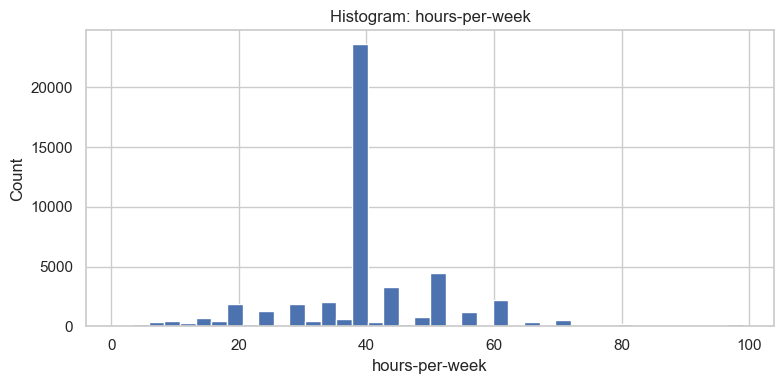

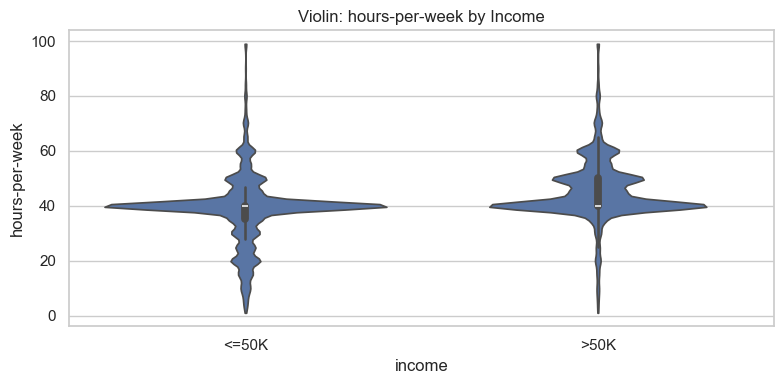

In [14]:
# ============================
# EDA Step 2:
# Numeric distributions, skewness, outliers
# ============================

def plot_hist(df, col, bins=30, log1p=False):
    x = df[col].dropna()
    if log1p:
        x = np.log1p(x)

    plt.figure(figsize=(8, 4))
    plt.hist(x, bins=bins)
    plt.title(f"Histogram: {col}" + (" (log1p)" if log1p else ""))
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def plot_violin_by_income(df, col, log1p=False):
    tmp = df[[col, target]].dropna().copy()
    if log1p:
        tmp[col] = np.log1p(tmp[col])

    plt.figure(figsize=(8, 4))
    sns.violinplot(data=tmp, x=target, y=col, cut=0)
    plt.title(f"Violin: {col} by Income" + (" (log1p)" if log1p else ""))
    plt.tight_layout()
    plt.show()

# Focus numeric features mentioned: hours-per-week, capital-gain
plot_hist(full, "hours-per-week", bins=40)
plot_violin_by_income(full, "hours-per-week")




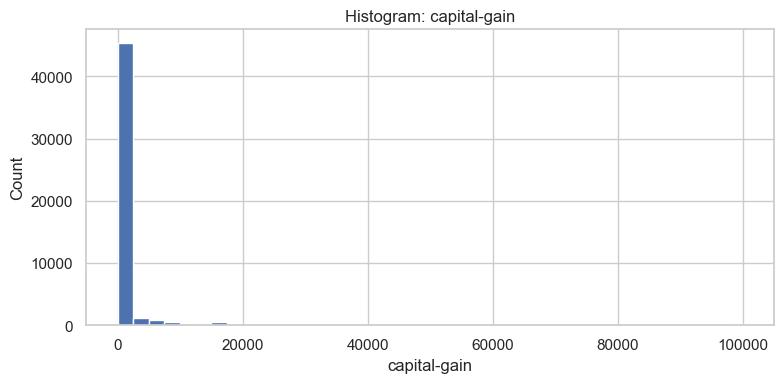

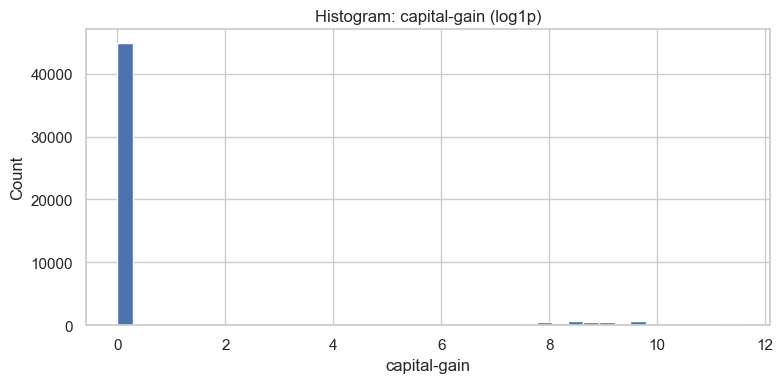

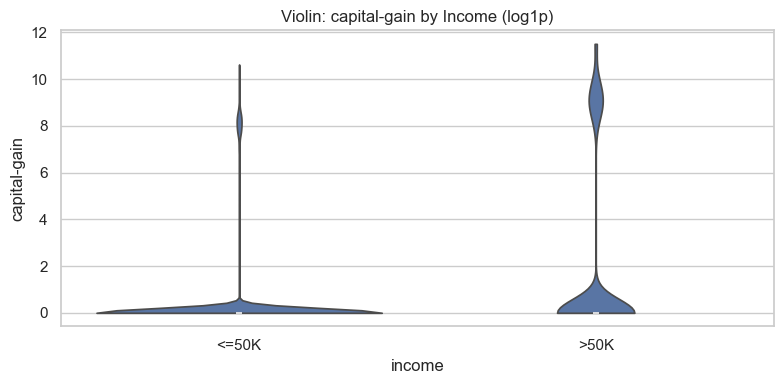

In [16]:
# capital-gain / loss are extremely skewed -> also show log1p views
plot_hist(full, "capital-gain", bins=40)
plot_hist(full, "capital-gain", bins=40, log1p=True)
plot_violin_by_income(full, "capital-gain", log1p=True)



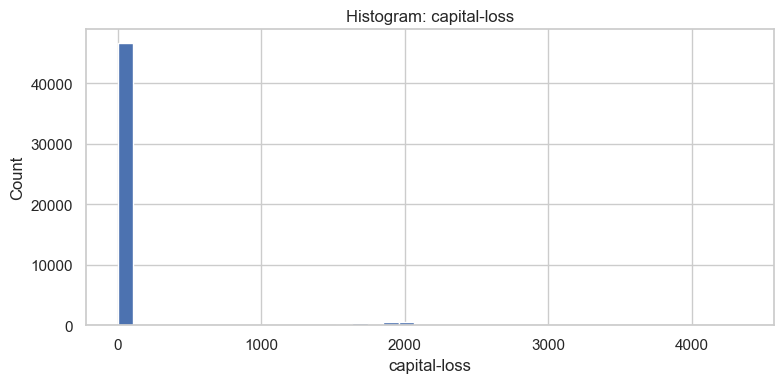

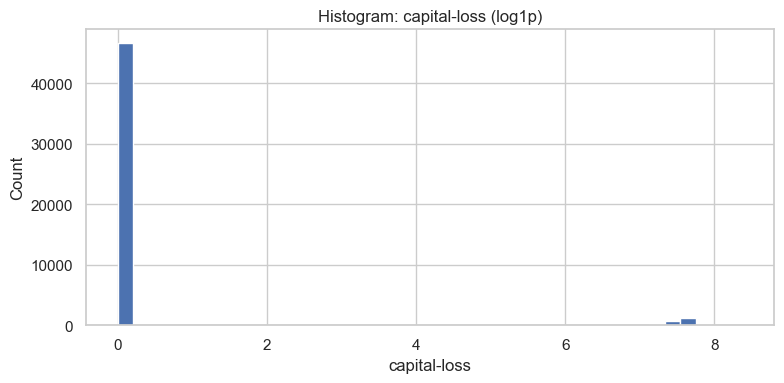

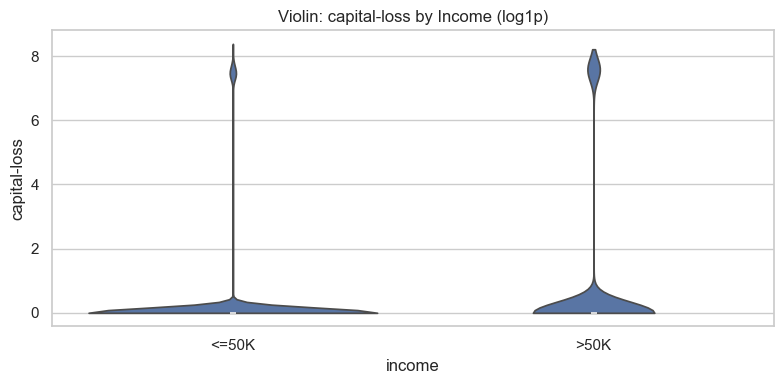

In [15]:
plot_hist(full, "capital-loss", bins=40)
plot_hist(full, "capital-loss", bins=40, log1p=True)
plot_violin_by_income(full, "capital-loss", log1p=True)

In [17]:
# Numeric summary + skewness
num_desc = full[num_cols].describe().T
num_desc["skew"] = full[num_cols].skew(numeric_only=True)
display(num_desc.sort_values("skew", ascending=False))


,count,mean,std,min,25%,50%,75%,max,skew
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0,11.894659
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0,4.569809
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0,1.438892
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0,0.557580
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0,0.238750
education-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0,-0.316525


In [18]:
# Simple outlier scan using IQR rule (counts)
def iqr_outlier_count(series):
    s = series.dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return int(((s < lo) | (s > hi)).sum())

outliers = []
for c in num_cols:
    outliers.append({
        "feature": c,
        "outlier_count_iqr": iqr_outlier_count(full[c]),
        "outlier_%": round(iqr_outlier_count(full[c]) / full[c].notna().sum() * 100, 2)
    })

outliers_df = pd.DataFrame(outliers).sort_values("outlier_%", ascending=False)
display(outliers_df)


,feature,outlier_count_iqr,outlier_%
5,hours-per-week,13496,27.63
3,capital-gain,4035,8.26
4,capital-loss,2282,4.67
2,education-num,1794,3.67
1,fnlwgt,1453,2.97
0,age,216,0.44


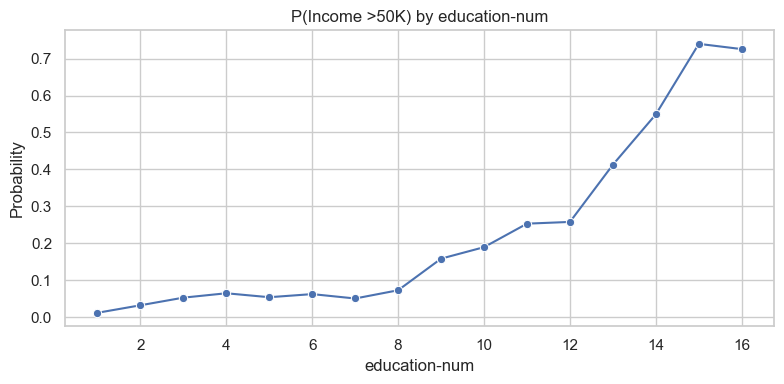

,education-num,p(>50K)
14,15,0.739808
15,16,0.725589
13,14,0.549116
12,13,0.412835
11,12,0.257964
10,11,0.253275
9,10,0.189649
8,9,0.158578
7,8,0.073059
3,4,0.064921


In [19]:
# ============================
# EDA Step 3:
# Relationships (cross-tabs + correlation)
# ============================

# 3A) Cross-tab: education-num vs income (mean encoding)
edu_income = full.groupby("education-num")[target].apply(lambda s: (s == ">50K").mean()).reset_index(name="p(>50K)")
plt.figure(figsize=(8, 4))
sns.lineplot(data=edu_income, x="education-num", y="p(>50K)", marker="o")
plt.title("P(Income >50K) by education-num")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

display(edu_income.sort_values("p(>50K)", ascending=False).head(10))


income,<=50K,>50K
education,,
Prof-school,0.260192,0.739808
Doctorate,0.274411,0.725589
Masters,0.450884,0.549116
Bachelors,0.587165,0.412835
Assoc-acdm,0.742036,0.257964
Assoc-voc,0.746725,0.253275
Some-college,0.810351,0.189649
HS-grad,0.841422,0.158578
12th,0.926941,0.073059


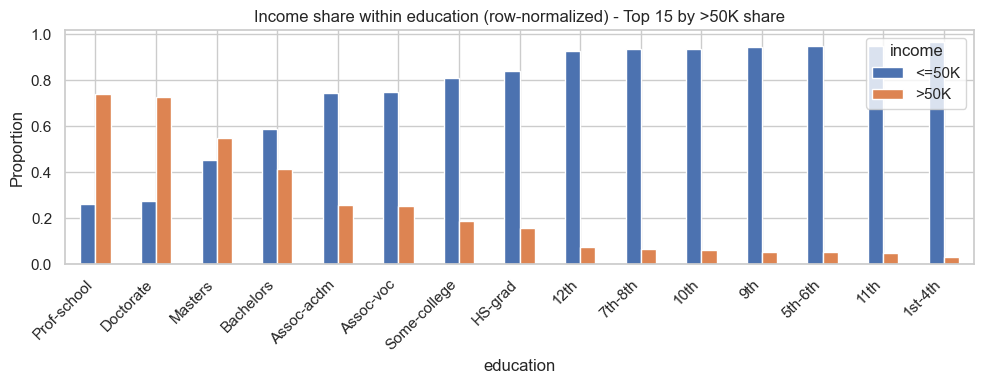

In [20]:
# 3B) Cross-tab: education (categorical) vs income
edu_ct = pd.crosstab(full["education"].fillna("__MISSING__"), full[target], normalize="index").sort_values(">50K", ascending=False)
display(edu_ct.head(15))

edu_ct.head(15).plot(kind="bar", figsize=(10, 4))
plt.title("Income share within education (row-normalized) - Top 15 by >50K share")
plt.ylabel("Proportion")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
